In [284]:
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import numpy as np
from math import cos
from sklearn.gaussian_process.kernels import RBF
from mpl_toolkits.mplot3d import Axes3D
import itertools
import sys
from python_scripts.bayesian_optimization import IBO
import time
import seaborn as sns
%pylab inline
%load_ext autoreload 

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cos']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [271]:
%autoreload 2

# This notebook assumes that you have an understanding of how Bayesian Optimization works.
- For a review, please visit the notebook Overview_of_Intelligent_Bayesian_Optimization

## We will compare my implementation of Bayesian Optimization with the bayesian_optimization package
> Bayesian_optimization package: https://github.com/fmfn/BayesianOptimization
- First, compare performance on a one-dimensional function
- Second, compare performance on a two-dimensional function
- Third, compare performance using an objective function to find the best hyperparameters of gradient boosting

### Define the one-dimensional function

In [194]:
oneD_function =lambda x: cos(1000*x-500)+(abs(x*100_000))/(x**4+1000)

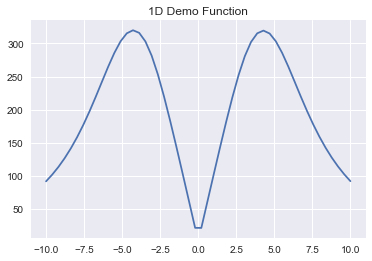

In [195]:
plt.plot(np.linspace(-10,10),[oneD_function(_) for _ in np.linspace(-10,10)])
plt.title('1D Demo Function');

### Setup the package Bayesian_Optimization

In [332]:
bayes_opt = BayesianOptimization(oneD_function,
                          {'x': (-10, 10)}) # the bounds to explore
bayes_opt .explore({'x': np.linspace(-10,10)}) # the points to explore

### Setup my implementation
- Import IBO (Intelligent Bayesian Optimization)

In [325]:
bo_implementation = IBO()

- Define the one train point, as well as the testing domain

In [326]:
test_x_oneD = np.array(np.linspace(-10,10,2_000)).reshape(-1,1)
train_x_oneD = np.array(np.random.choice(test_x.ravel())).reshape(-1,1)
train_y_numbers_oneD = np.array([oneD_function(_) for _ in train_x]).reshape(-1,1)

- Fit the gaussian process from IBO

In [327]:
bo_implementation.fit(train_x_oneD,train_y_numbers_oneD, test_x_oneD, oneD_function, y_func_type='real' )

- There are two primary methods in my implementation
        - 1) Predict: predict the next x-coordinates
        - 2) Maximize: try to find the best x-coordinates given the number of steps

# Run one trial of the bayes_opt vs my implementataion
### Compare performance and time

- My implementation

In [328]:
# find the max
start_my_bo = time.time()
bo_implementation.maximize(n_steps=10)
end_my_bo = time.time()

Bayesian Optimization just sampled point = [ 3.1865933]
Best x (Bayesian Optimization) = [ 3.1865933],                         Best y = [ 288.01120847]
Bayesian Optimization just sampled point = [ 3.38669335]
Best x (Bayesian Optimization) = [ 3.38669335], Best y = [ 298.3869829]
Bayesian Optimization just sampled point = [ 3.79689845]
Best x (Bayesian Optimization) = [ 3.79689845], Best y = [ 314.15441828]
Bayesian Optimization just sampled point = [ 3.2066033]
Best x (Bayesian Optimization) = [ 3.79689845], Best y = [ 314.15441828]
Bayesian Optimization just sampled point = [ 3.36668334]
Best x (Bayesian Optimization) = [ 3.79689845], Best y = [ 314.15441828]
Bayesian Optimization just sampled point = [ 4.19709855]
Best x (Bayesian Optimization) = [ 4.19709855], Best y = [ 319.4638755]
Bayesian Optimization just sampled point = [ 5.17758879]
Best x (Bayesian Optimization) = [ 4.19709855], Best y = [ 319.4638755]
Bayesian Optimization just sampled point = [ 4.52726363]
Best x (Bayesia

- Bayes Opt implementation
- Ensure to use the same number of initialization points, same number of steps, same acquisition function (Expected Improvement)

In [333]:
start_bayes_opt = time.time()
bayes_opt .maximize(init_points=1, n_iter=10, acq='ei') # ei = expected improvement
end_bayes_opt = time.time()

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 00m00s |  315.31580 |   -4.6939 | 
   15 | 00m00s |  319.97963 |   -4.2857 | 
   16 | 00m00s |  316.00478 |   -3.8776 | 
   17 | 00m00s |  303.02024 |   -3.4694 | 
   18 | 00m00s |  281.63698 |   -3.0612 | 
   19 | 00m00s |  253.23789 |   -2.6531 | 
   20 | 00m00s |  219.58655 |   -2.2449 | 
   21 | 00m00s |  182.42609 |   -1.8367 

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.52453594]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   55 | 00m01s |  320.80285 |   -4.2426 | 
   56 | 00m01s |  321.25755 |   -4.2119 | 
   57 | 00m03s |  319.59456 |   -4.2275 | 
   58 | 00m03s |  321.03280 |   -4.1928 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.14630812]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   59 | 00m02s |  320.72717 |   -4.2049 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.19919738]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.18158552]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-17427.12230572]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 30, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jonathanhilgart/a

   60 | 00m03s |  321.43131 |   -4.2376 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.88750339]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-23.89322162]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   61 | 00m03s |  321.27788 |   -4.2381 | 


#### Compare the results

In [329]:
print(f"The best y-value from my bayesian optimization implementation was {bo_implementation.best_y}.\
      The best x-coordiantes from my bayesian optimiztion implementation was {bo_implementation.best_x}.\
      My implementation took {round(end_my_bo -start_my_bo,2)} seconds for 10 steps")

The best y-value from my bayesian optimization implementation was [ 319.76786769].      The best x-coordiantes from my bayesian optimiztion implementation was [ 4.52726363].      My implementation took 58.25 seconds for 10 steps


In [334]:
print(f" The best values from the Bayes_Opt package was {bayes_opt.res['max']}.\
    The Bayes_Opt implementation took {round(end_bayes_opt -start_bayes_opt,2) } seconds for 10 steps")

 The best values from the Bayes_Opt package was {'max_val': 321.43131427152485, 'max_params': {'x': -4.2375673129286318}}.    The Bayes_Opt implementation took 27.22 seconds for 10 steps


- The Bayes_Opt package beat my implementation in time and speed

## Run each implmentation for 10 trials of 10 steps. See how many times each algo wins.
- One dimensional implementation

In [281]:
# keep track of the wins
my_implementation_wins = 0
bayes_opt_wins = 0

n_trials=10
for i in range(n_trials):
    print('Step Number =',i+1)
    # My implementation
    bo_implementation.fit(train_x_oneD,train_y_numbers_oneD, test_x_oneD, oneD_function, 
                          y_func_type='real', verbose = False )
    bo_implementation.maximize()
    # Bayes Opt Implementation
    bayes_opt = BayesianOptimization(oneD_function,
                          {'x': (-10, 10)}) # the range to explore
    bayes_opt .explore({'x': np.linspace(-10,10)}) # the points to explore
    bayes_opt .maximize(init_points=1, n_iter=10, acq='ei')
    
    if bayes_opt.res['max']['max_val'] > bo_implementation.best_y:
        print("Bayes Opt Won")
        bayes_opt_wins +=1
    else:
        print('My implementation won')
        my_implementation_wins +=1 
    

Step Number = 1
Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 00m00s |  315.31580 |   -4.6939 | 
   15 | 00m00s |  319.97963 |   -4.2857 | 
   16 | 00m00s |  316.00478 |   -3.8776 | 
   17 | 00m00s |  303.02024 |   -3.4694 | 
   18 | 00m00s |  281.63698 |   -3.0612 | 
   19 | 00m00s |  253.23789 |   -2.6531 | 
   20 | 00m00s |  219.58655 |   -2.2449 | 
   21 | 00m00s |  182.42

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.04911578]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   53 | 00m01s |  319.15748 |   -4.1531 | 
   54 | 00m01s |  321.32829 |   -4.2371 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2855.25666682]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 34, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/bayes_opt/helpers.py:101: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


   55 | 00m01s |  321.32484 |   -4.2433 | 
   56 | 00m01s |  320.21777 |   -4.2393 | 
   57 | 00m01s |  320.92728 |   -4.2052 | 
   58 | 00m02s |  321.40137 |   -4.2249 | 
   59 | 00m02s |  321.29894 |   -4.2506 | 
   60 | 00m02s |  321.04138 |   -4.2321 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.41926343]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   61 | 00m03s |  319.72784 |   -4.2462 | 
Bayes Opt Won
Step Number = 2
Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 00m00s |  315.31580 |   -4.6939 | 
   15 | 00m00s |  319.97963 |   -4.2857 | 
   16 | 00m00s |  316.00478 |   -3.8776 | 
   17 | 00m00s |  303.02024 |   -3.4694 | 
   18 | 00m00s |  281.63698 |   -3.0612 | 
   19 | 00m00s |  253.23789 |   -2.6531 | 
   20 | 00

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.54976831]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   54 | 00m01s |  321.27264 |   -4.2370 | 
   55 | 00m01s |  319.44777 |   -4.2469 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.59775613]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


   56 | 00m01s |  320.11636 |   -4.2079 | 
   57 | 00m01s |  319.46820 |   -4.2284 | 
   58 | 00m01s |  321.38464 |   -4.2693 | 
   59 | 00m02s |  321.45535 |   -4.2691 | 
   60 | 00m02s |  320.76590 |   -4.2677 | 
   61 | 00m02s |  320.98690 |   -4.1802 | 
Bayes Opt Won
Step Number = 3
Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 00m00s |  315.31580 |   -4.6939 | 
   15 | 00

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.32676724]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   54 | 00m01s |  321.40454 |   -4.2373 | 
   55 | 00m02s |  319.81629 |   -4.2416 | 
   56 | 00m02s |  321.27697 |   -4.2065 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.18812683]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


   57 | 00m02s |  321.33290 |   -4.2253 | 
   58 | 00m02s |  320.34598 |   -4.2329 | 
   59 | 00m02s |  321.07614 |   -4.2179 | 
   60 | 00m02s |  320.31758 |   -4.2707 | 
   61 | 00m02s |  319.80252 |   -4.1956 | 
Bayes Opt Won
Step Number = 4
Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 00m00s |  315.31580 |   -4.6939 | 
   15 | 00m00s |  319.97963 |   -4.2857 | 
   16 | 00

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.86554539]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


   56 | 00m02s |  320.76238 |   -4.2451 | 
   57 | 00m02s |  319.44189 |   -4.2408 | 
   58 | 00m02s |  321.21515 |   -4.2003 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-974.8617298]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 30, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)


   59 | 00m02s |  320.74893 |   -4.2237 | 
   60 | 00m02s |  320.05086 |   -4.1730 | 
   61 | 00m02s |  320.85551 |   -4.2324 | 
Bayes Opt Won
Step Number = 5
Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 00m00s |  315.31580 |   -4.6939 | 
   15 | 00m00s |  319.97963 |   -4.2857 | 
   16 | 00m00s |  316.00478 |   -3.8776 | 
   17 | 00m00s |  303.02024 |   -3.4694 | 
   18 | 00

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.07866585]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   52 | 00m03s |  321.06645 |   -4.2636 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.1511369]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   53 | 00m01s |  319.08179 |   -4.1527 | 
   54 | 00m01s |  321.42940 |   -4.2374 | 
   55 | 00m02s |  319.45205 |   -4.2408 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.07765566]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   56 | 00m02s |  321.19465 |   -4.2055 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.36414644]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   57 | 00m02s |  321.40258 |   -4.2250 | 
   58 | 00m01s |  320.62671 |   -4.2326 | 
   59 | 00m01s |  320.74318 |   -4.2175 | 
   60 | 00m03s |  320.09760 |   -4.2709 | 
   61 | 00m03s |  319.74145 |   -4.1914 | 
Bayes Opt Won
Step Number = 6
Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 00m00s |  315.31580 |   -4.6939 | 
   15 | 00m00s |  319.97963 |   -4.2857 | 
   16 | 00

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03610532]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   52 | 00m07s |  321.01583 |   -4.2636 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.09802756]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   53 | 00m03s |  319.40458 |   -4.1535 | 
   54 | 00m02s |  319.99217 |   -4.2355 | 
   55 | 00m03s |  321.30913 |   -4.2621 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.23751804]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   56 | 00m05s |  320.12102 |   -4.2545 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.63332582]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   57 | 00m04s |  320.29345 |   -4.2609 | 
   58 | 00m03s |  321.42902 |   -4.2624 | 
   59 | 00m04s |  320.23879 |   -4.1732 | 
   60 | 00m03s |  321.46115 |   -4.2627 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-12735.2021785]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)


   61 | 00m03s |  319.61093 |   -4.2464 | 
Bayes Opt Won
Step Number = 7
Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 00m00s |  315.31580 |   -4.6939 | 
   15 | 00m00s |  319.97963 |   -4.2857 | 
   16 | 00m00s |  316.00478 |   -3.8776 | 
   17 | 00m00s |  303.02024 |   -3.4694 | 
   18 | 00m00s |  281.63698 |   -3.0612 | 
   19 | 00m00s |  253.23789 |   -2.6531 | 
   20 | 00

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.59108616]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   59 | 00m02s |  321.07061 |   -4.1879 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.10487248]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   60 | 00m02s |  321.21175 |   -4.3123 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1590.83918029]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 34, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


   61 | 00m02s |  319.94978 |   -4.2648 | 
Bayes Opt Won
Step Number = 8
Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 00m00s |  315.31580 |   -4.6939 | 
   15 | 00m00s |  319.97963 |   -4.2857 | 
   16 | 00m00s |  316.00478 |   -3.8776 | 
   17 | 00m00s |  303.02024 |   -3.4694 | 
   18 | 00m00s |  281.63698 |   -3.0612 | 
   19 | 00m00s |  253.23789 |   -2.6531 | 
   20 | 00

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.18822115]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   54 | 00m01s |  321.40297 |   -4.2373 | 
   55 | 00m02s |  319.49782 |   -4.2410 | 
   56 | 00m02s |  321.28186 |   -4.2057 | 
   57 | 00m01s |  321.39963 |   -4.2249 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01026041]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   58 | 00m02s |  320.78759 |   -4.2324 | 
   59 | 00m01s |  320.71175 |   -4.2174 | 
   60 | 00m01s |  320.08879 |   -4.1918 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.82733734]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   61 | 00m01s |  320.18192 |   -4.2708 | 
Bayes Opt Won
Step Number = 9
Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 00m00s |  315.31580 |   -4.6939 | 
   15 | 00m00s |  319.97963 |   -4.2857 | 
   16 | 00m00s |  316.00478 |   -3.8776 | 
   17 | 00m00s |  303.02024 |   -3.4694 | 
   18 | 00m00s |  281.63698 |   -3.0612 | 
   19 | 00m00s |  253.23789 |   -2.6531 | 
   20 | 00

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.60229842]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


   55 | 00m02s |  320.25669 |   -4.2581 | 
   56 | 00m02s |  321.24676 |   -4.2696 | 
   57 | 00m01s |  320.90001 |   -4.1945 | 
   58 | 00m01s |  319.88297 |   -4.2648 | 
   59 | 00m01s |  321.46508 |   -4.2752 | 
   60 | 00m02s |  319.50270 |   -4.2724 | 
   61 | 00m02s |  320.84812 |   -4.1629 | 
Bayes Opt Won
Step Number = 10
Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   91.60769 |  -10.0000 | 
    2 | 00m00s |  101.84945 |   -9.5918 | 
    3 | 00m00s |  113.47606 |   -9.1837 | 
    4 | 00m00s |  126.66415 |   -8.7755 | 
    5 | 00m00s |  141.57709 |   -8.3673 | 
    6 | 00m00s |  158.33855 |   -7.9592 | 
    7 | 00m00s |  176.99157 |   -7.5510 | 
    8 | 00m00s |  197.43956 |   -7.1429 | 
    9 | 00m00s |  219.36796 |   -6.7347 | 
   10 | 00m00s |  242.15235 |   -6.3265 | 
   11 | 00m00s |  264.77197 |   -5.9184 | 
   12 | 00m00s |  285.76658 |   -5.5102 | 
   13 | 00m00s |  303.29087 |   -5.1020 | 
   14 | 0

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.06798105]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   53 | 00m02s |  320.50233 |   -4.1507 | 
   54 | 00m01s |  321.40445 |   -4.2249 | 
   55 | 00m01s |  321.37099 |   -4.2434 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.3143575]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   56 | 00m01s |  321.07374 |   -4.2241 | 
   57 | 00m01s |  320.09642 |   -4.0622 | 
   58 | 00m01s |  321.18256 |   -4.2319 | 
   59 | 00m02s |  320.48751 |   -4.1173 | 
   60 | 00m01s |  319.71433 |   -4.2273 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0847015]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   61 | 00m02s |  320.97743 |   -4.2365 | 
Bayes Opt Won


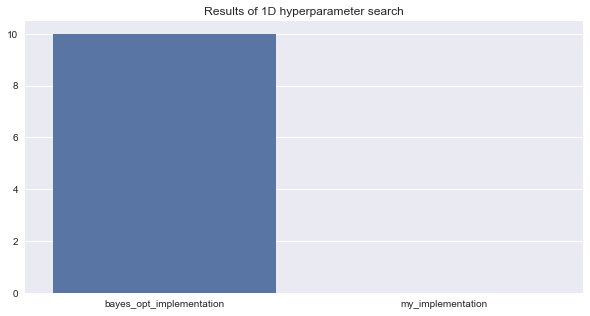

In [286]:
plt.figure(figsize=(10,5))
plt.title('Results of 1D hyperparameter search')
sns.barplot(x = ['bayes_opt_implementation','my_implementation'],y =[bayes_opt_wins, my_implementation_wins] );

- Not a huge suprise that the 'professional' implementation outperforms my implementation

# Next, compare performance over a two-dimensional function

### Eggholder function 

${\displaystyle f(x,y)=-\left(y+47\right)\sin {\sqrt {\left|{\frac {x}{2}}+\left(y+47\right)\right|}}-x\sin {\sqrt {\left|x-\left(y+47\right)\right|}}} $

In [374]:
#twoD_function = lambda x,y: 100*np.sqrt(abs(y-.01*x**2))+.01*abs(x+10)
twoD_function = lambda x,y: -(y+47)*sin(np.sqrt(abs((x/2)+(y+47))))-x*sin(np.sqrt(abs(x-(y+47))))

In [563]:
twoD_domain = np.linspace(-100,100,60)
combo_domain = list(itertools.product(*[twoD_domain,twoD_domain]))
twoD_train_x = np.array([combo_domain[np.random.choice(len(combo_domain))] ] )
twoD_train_y = np.array([twoD_function(twoD_train_x[0][0],twoD_train_x[0][1])).reshape(-1,1)
# Define the axes for the scatter plot
xs = [combo_domain[i][0] for i in range(len(combo_domain))]
ys = [combo_domain[i][1] for i in range(len(combo_domain))]

SyntaxError: invalid syntax (<ipython-input-563-b91dc257519b>, line 4)

In [449]:
print(f"The domain has {len(combo_domain):,} parameters")

The domain has 3,600 parameters


In [450]:
twoD_function_y = np.array([twoD_function(combo_domain[i][0],combo_domain[i][1]) for i in range(len(combo_domain))]).reshape(-1,1)

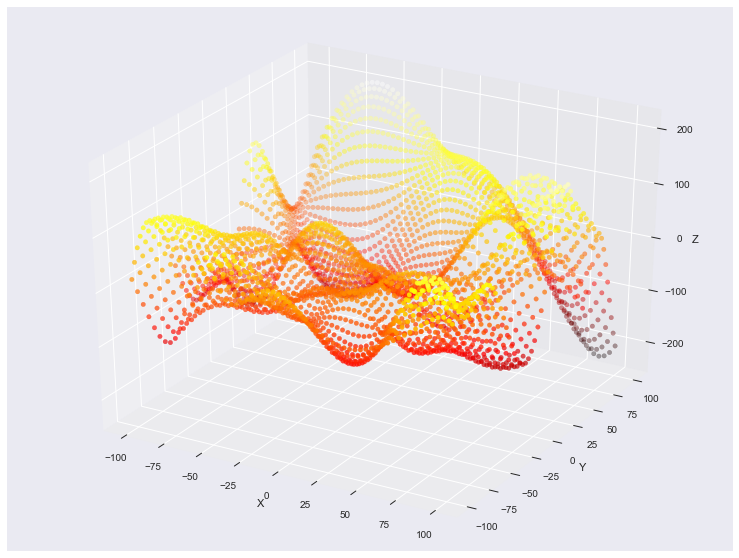

In [425]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, twoD_function_y,cmap='hot',c=twoD_function_y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z');

### Setup my implementation

In [555]:
%autoreload 2

In [560]:
bo_implementation_2d.fit(twoD_train_x, twoD_train_y ,combo_domain, twoD_function , y_func_type='real',
                        kernel_params={'length':50}) # change the length parameter

### Setup the bayesian_optimization implementation

In [508]:
bayes_opt_2d = BayesianOptimization(twoD_function ,
                          {'x': (-100,100),'y':(-100,100)}) # the bounds to explore
bayes_opt_2d .explore({'x': np.linspace(-100,100,60),'y':np.linspace(-100,100,60)}) # the points to explore

## Compare two-dimensional results

In [561]:
my_implementation_2d_s = time.time()
bo_implementation_2d.maximize()
my_implementation_2d_e = time.time()

Bayesian Optimization just sampled point = [ 96.61016949  38.98305085]
Best x (Bayesian Optimization) = [ 96.61016949  38.98305085],                         Best y = [ 82.72288041]
Bayesian Optimization just sampled point = (96.610169491525426, 35.593220338983031)
Best x (Bayesian Optimization) = (96.610169491525426, 35.593220338983031), Best y = 129.2673021437016
Bayesian Optimization just sampled point = (100.0, 35.593220338983031)
Best x (Bayesian Optimization) = (100.0, 35.593220338983031), Best y = 157.46133936416348
Bayesian Optimization just sampled point = (-100.0, 96.610169491525426)
Best x (Bayesian Optimization) = (100.0, 35.593220338983031), Best y = 157.46133936416348
Bayesian Optimization just sampled point = (100.0, 38.983050847457633)
Best x (Bayesian Optimization) = (100.0, 35.593220338983031), Best y = 157.46133936416348
Bayesian Optimization just sampled point = (100.0, 42.372881355932208)
Best x (Bayesian Optimization) = (100.0, 35.593220338983031), Best y = 157.461

In [562]:
bayes_opt_2d_time_s = time.time()
bayes_opt_2d.maximize(init_points=1, n_iter=10, acq='ei')
bayes_opt_2d_time_e = time.time()

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
    1 | 00m00s |   19.05993 | -100.0000 | -100.0000 | 
    2 | 00m00s |   29.84759 |  -96.6102 |  -96.6102 | 
    3 | 00m00s |   40.85957 |  -93.2203 |  -93.2203 | 
    4 | 00m00s |   51.12372 |  -89.8305 |  -89.8305 | 
    5 | 00m00s |   59.71687 |  -86.4407 |  -86.4407 | 
    6 | 00m00s |   65.84925 |  -83.0508 |  -83.0508 | 
    7 | 00m00s |   68.95078 |  -79.6610 |  -79.6610 | 
    8 | 00m00s |   68.75080 |  -76.2712 |  -76.2712 | 
    9 | 00m00s |   65.34069 |  -72.8814 |  -72.8814 | 
   10 | 00m00s |   59.20652 |  -69.4915 |  -69.4915 | 
   11 | 00m00s |   51.21656 |  -66.1017 |  -66.1017 | 
   12 | 00m00s |   42.54804 |  -62.7119 |  -62.7119 | 
   13 | 00m00s |   34.53798 |  -59.3220 |  -59.3220 | 
   14 | 00m00s |   28.44758 |  -55.9322 |  -55.9322 | 
   15 | 00m00s |   25.14023 |  -52.5424 |  -52.5424 | 
   16 | 00m00s |   24.69531 |  -49.1525 |  -49.1525

In [566]:
print(f"The best y-value from my bayesian optimization implementation was {bo_implementation_2d.best_y}.\
      The best x-coordiantes from my bayesian optimiztion implementation was {bo_implementation_2d.best_x}.\
      My implementation took {round(my_implementation_2d_e -my_implementation_2d_s,2)} seconds for 10 steps")

The best y-value from my bayesian optimization implementation was 157.92386513208135.      The best x-coordiantes from my bayesian optimiztion implementation was (-32.203389830508485, 96.610169491525426).      My implementation took 124.39 seconds for 10 steps


In [567]:
print(f" The best values from the Bayes_Opt package was {bayes_opt_2d.res['max']}.\
    The Bayes_Opt implementation took {round(bayes_opt_2d_time_e -bayes_opt_2d_time_s,2) } seconds for 10 steps")

 The best values from the Bayes_Opt package was {'max_val': 148.81627716027575, 'max_params': {'x': 63.713397849339685, 'y': 38.959575019263241}}.    The Bayes_Opt implementation took 27.37 seconds for 10 steps


# Run this two dimensional parameter search ten times to compare perforamnce

In [ ]:
# keep track of the wins
my_implementation_wins_2d = 0
bayes_opt_wins_2d = 0

n_trials=10
for i in range(n_trials):
    print('Step Number =',i+1)
    # My implementation
    bo_implementation_2d.fit(twoD_train_x, twoD_train_y ,combo_domain, twoD_function , y_func_type='real',
                        kernel_params={'length':50}, verbose=False) # change the length parameter
    bo_implementation_2d.maximize()
    # Bayes Opt Implementation
    bayes_opt_2d = BayesianOptimization(twoD_function ,
                          {'x': (-100,100),'y':(-100,100)}) # the bounds to explore
    bayes_opt_2d .explore({'x': np.linspace(-100,100,60),'y':np.linspace(-100,100,60)}) # the points to explore
    bayes_opt_2d .maximize(init_points=1, n_iter=10, acq='ei')
    
    if bayes_opt_2d.res['max']['max_val'] > bo_implementation_2d.best_y:
        print("Bayes Opt Won")
        bayes_opt_wins_2d +=1
    else:
        print('My implementation won')
        my_implementation_wins_2d +=1 
    

Step Number = 1
